## CSI 4900- Community detection using GNN

<h4>Importing Necessary Libraries</h4>

In [ ]:
%matplotlib inline
!pip install numpy pandas matplotlib networkx torch torch_geometric

import json
import requests
import collections
import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from torch_geometric.data import Data
from torch_geometric.utils.convert import to_networkx
from torch_geometric.nn import GCNConv

import networkx as nx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.3 MB/s eta 0:00:00


<h4>Pre-processing the Dataset</h4>
<hr>



In [ ]:
# URL of the JSON file on GitHub
json_url = "https://raw.githubusercontent.com/mehtameet12/GNN_Dataset/main/musae_git_features.json"

# Fetch JSON data from the URL
response = requests.get(json_url)
data_raw = json.loads(response.text)

# URL of the CSV file containing edges on GitHub
edges_url = "https://raw.githubusercontent.com/mehtameet12/GNN_Dataset/main/musae_git_edges.csv"

# Fetch edge data from the CSV file URL
edges = pd.read_csv(edges_url)

# URL of the CSV file containing target data on GitHub
target_url = "https://raw.githubusercontent.com/mehtameet12/GNN_Dataset/main/musae_git_target.csv"

# Fetching target data from the CSV file URL
target_df = pd.read_csv(target_url)


In [ ]:
print("Printing the first 5 nodes of the Dataset")
target_df.head()

Printing the first 5 nodes of the Dataset


,id,name,ml_target
0,0,Eiryyy,0
1,1,shawflying,0
2,2,JpMCarrilho,1
3,3,SuhwanCha,0
4,4,sunilangadi2,1


In [ ]:
print("Printing the last 5 nodes of the Dataset")
target_df.tail()

Printing the last 5 nodes of the Dataset


,id,name,ml_target
37695,37695,shawnwanderson,1
37696,37696,kris-ipeh,0
37697,37697,qpautrat,0
37698,37698,Injabie3,1
37699,37699,caseycavanagh,0


<h4>Processing the Dataset</h4>
<hr>

In [ ]:
#feats is a list that will concatenate and store all the individual features from all 37,700 nodes
feats=[]

#feat_counts is a list that will store the length (which indicates the number of features) each node has
feat_counts=[]
for i in range(len(data_raw)):
    feat_counts+=[len(data_raw[str(i)])]
    feats+=data_raw[str(i)]


In [ ]:
#We are counting the frequency of each feature and storing it in a dictionary called counter
counter=collections.Counter(feats)

<h4>Data Analysis</h4>
<hr>

In [ ]:
print('Printing the number of feature that first 5 nodes contain \n')
print(feat_counts[:5])


Printing the number of feature that first 5 nodes contain 

[19, 17, 19, 15, 19]


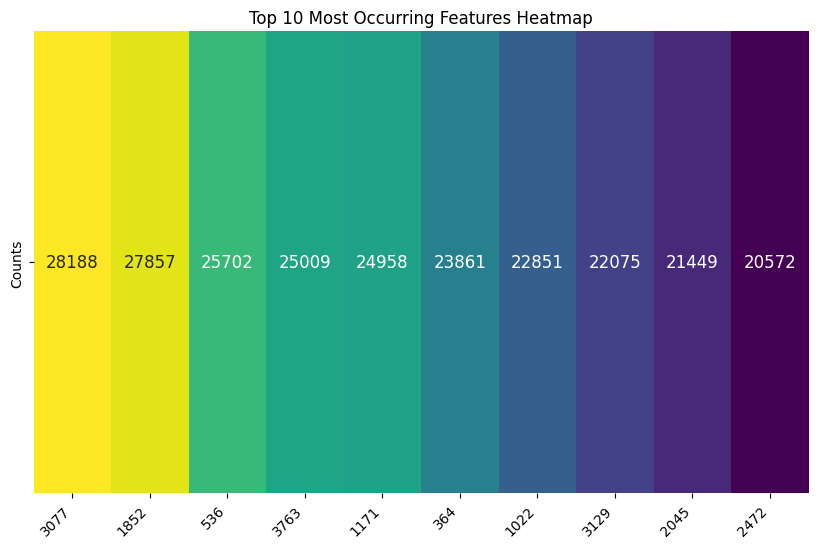

In [ ]:


top_features = [feature for feature, count in counter.most_common(10)]
top_feature_counts = [count for feature, count in counter.most_common(10)]

# Create a DataFrame for the top features and their counts
top_features_df = pd.DataFrame({'Features': top_features, 'Counts': top_feature_counts})

top_features_df = top_features_df.sort_values(by='Counts', ascending=False)

# Increase the size of the heatmap figure
plt.figure(figsize=(10, 6))

# Create a heatmap with feature counts
sns.heatmap(top_features_df[['Counts']].T, cmap='viridis', annot=True, fmt='d', annot_kws={"size": 12}, cbar=False)

# Set the x-axis labels to feature names
plt.xticks(ticks=[i + 0.5 for i in range(10)], labels=top_features, rotation=45, ha='right')

plt.title('Top 10 Most Occurring Features Heatmap')
plt.show()


<h4>Data Encoding</h4>
<hr>

In [ ]:
#Encoding the Data
def encode_data(light=False,n=60):
  #Trying to work with only 60 nodes due to limited computer resources
    if light==True:
        nodes_included=n
    elif light==False:
        nodes_included=len(data_raw)

  #data_encoded dictionary will store all a list of all 4005 features for every (37,700) nodes filled with 1's and 0's depending on the presence of each feature
    data_encoded={}
    for i in range(nodes_included):#
        one_hot_feat=np.array([0]*(max(feats)+1))
        this_feat=data_raw[str(i)]
        one_hot_feat[this_feat]=1
        data_encoded[str(i)]=list(one_hot_feat)

  #Sice the value (list) of each key (node) is 4005 elements long, mostly containing 1's and 0's, we are creating a sparse matrix
    if light==True:
        sparse_feat_matrix=np.zeros((1,max(feats)+1))
        for j in range(nodes_included):
            temp=np.array(data_encoded[str(j)]).reshape(1,-1)
            sparse_feat_matrix=np.concatenate((sparse_feat_matrix,temp),axis=0)
        sparse_feat_matrix=sparse_feat_matrix[1:,:]
        return(data_encoded,sparse_feat_matrix)
    elif light==False:
        return(data_encoded, None)

<h5>Sparse Matrix plotting the first 550 features in the first 100 nodes</h5>

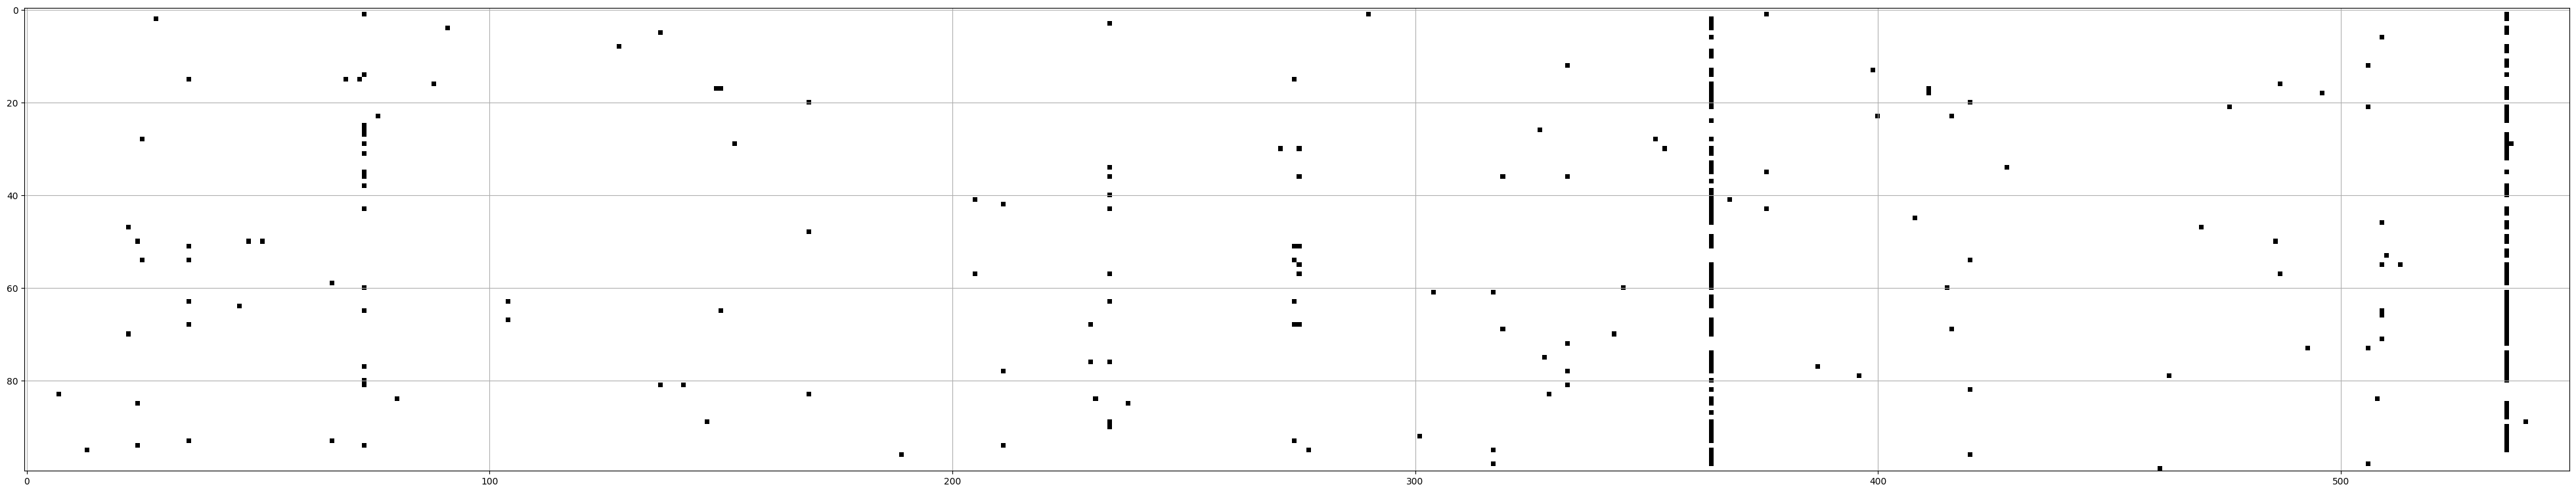

In [ ]:
#since we cannot fit all 4005 features in the window, we are showing the first 550 feautures of the first 100 nodes by passing the value to the encoded function which will return a sparse matrix
data_encoded_vis,sparse_feat_matrix_vis=encode_data(light=True,n=100)
plt.figure(figsize=(50,50));
plt.imshow(sparse_feat_matrix_vis[:,:550],cmap='Greys');
plt.grid()

<h4> Constructing a Graph </h4>
<hr>

In [ ]:
def construct_graph(data_encoded, light=False):
    # Extract the node features from the input data and convert them to a tensor.
    node_features_list = list(data_encoded.values())
    node_features = torch.tensor(node_features_list)

    # Extract node labels from the 'target_df' dataframe and convert them to a tensor.
    node_labels = torch.tensor(target_df['ml_target'].values)

    # Prepare the edge data from the 'edges' variable and create edge tensors.
    edges_list = edges.values.tolist()
    edge_index01 = torch.tensor(edges_list, dtype=torch.long).T
    edge_index02 = torch.zeros(edge_index01.shape, dtype=torch.long)

    # Create reverse edges by swapping source and target indices.
    edge_index02[0, :] = edge_index01[1, :]
    edge_index02[1, :] = edge_index01[0, :]

    # Concatenate both the original and reverse edges to create a combined edge index.
    edge_index0 = torch.cat((edge_index01, edge_index02), axis=1)

    # Create a PyTorch Geometric 'Data' object representing the graph with node features, labels, and edges.
    g = Data(x=node_features, y=node_labels, edge_index=edge_index0)

    # Create a "light" version of the graph with reduced dimensions.
    g_light = Data(x=node_features[:, 0:2], y=node_labels, edge_index=edge_index0[:, :55])

    # If the 'light' parameter is True, return the light version; otherwise, return the full graph.
    if light:
        return g_light
    else:
        return g


In [ ]:
def draw_graph(data0):
    # Check if the graph has more than 100 nodes.
    if data0.num_nodes > 100:
        # If it's a large graph, print a message and exit without plotting.
        print("This is a big graph, cannot plot...")
        return

    else:
        # Convert the input PyTorch Geometric 'Data' object to a NetworkX graph.
        data_nx = to_networkx(data0)

        # Extract node colors from the 'data0' object based on node labels.
        node_colors = data0.y[list(data_nx.nodes)]

        # Compute the positions of nodes using the spring layout algorithm.
        pos = nx.spring_layout(data_nx, scale=1)

        # Create a Matplotlib figure for the graph visualization.
        plt.figure(figsize=(12, 8))

        # Use NetworkX to draw the graph with various visualization settings.
        nx.draw(data_nx, pos, cmap=plt.get_cmap('Set1'),
                node_color=node_colors, node_size=600, connectionstyle="angle3",
                width=1, with_labels=True, edge_color='k', arrowstyle="-")


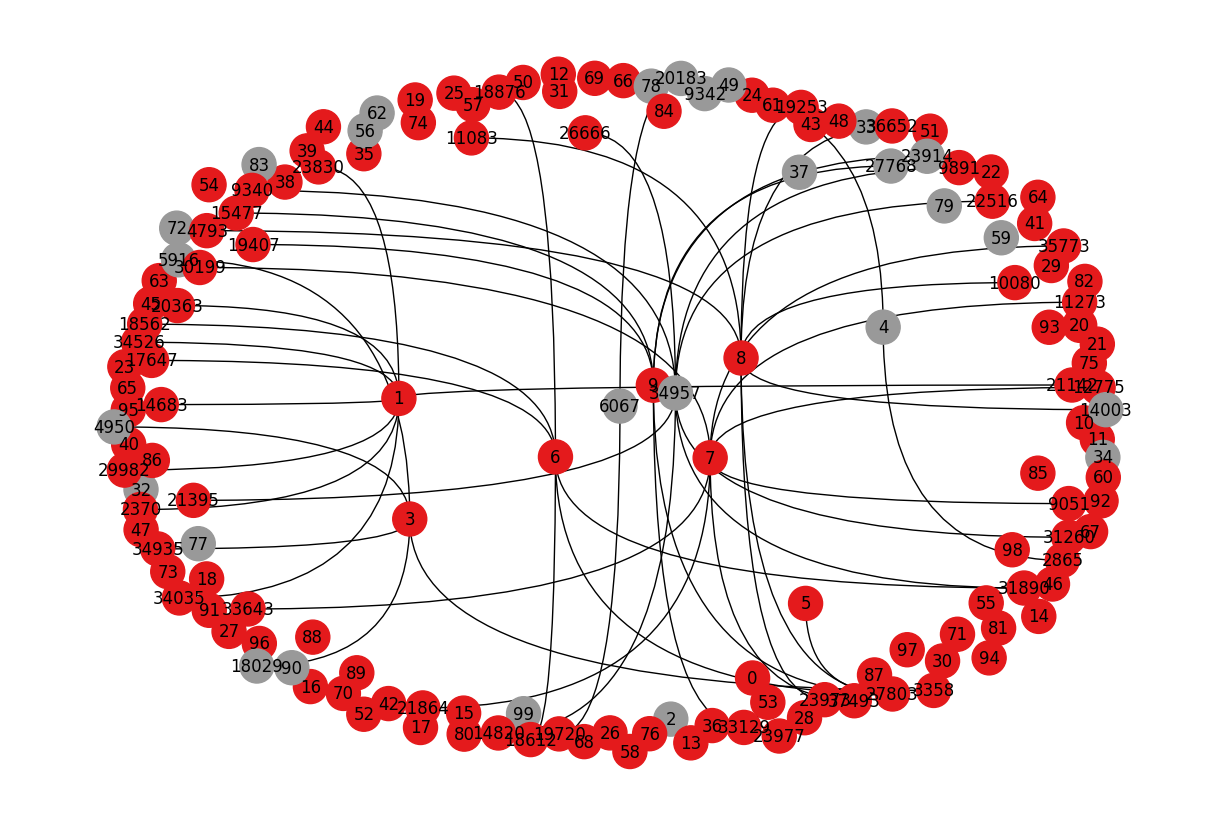

In [ ]:
# Constructing the graph with 'g_light' representing the connection of edges.
# The gray color represents Machine Learning (ML) while the Red represents Web Development.

# The 'light' version is suitable for visualization with reduced dimensions.
g_sample = construct_graph(data_encoded=data_encoded_vis, light=True)

# Visualize the 'g_sample' graph.
draw_graph(g_sample)

**GNN Model Construction**

In [ ]:
data_encoded,_=encode_data(light=False)

In [ ]:
g=construct_graph(data_encoded=data_encoded,light=False)

In [ ]:
# Define the labels/targets (assuming they are in g)
labels = g.y

# Split the data into training, validation, and test sets based on the ration shown below
train_ratio = 0.6
val_ratio = 0.3
test_ratio = 0.1

train_idx, test_idx, train_labels, test_labels = train_test_split(
    range(len(labels)), labels, test_size=test_ratio, random_state=42
)

train_idx, val_idx, train_labels, val_labels = train_test_split(
    train_idx, train_labels, test_size=val_ratio / (1 - test_ratio), random_state=42
)

# Create mask tensors for training, validation, and test sets
train_mask = torch.zeros(len(labels), dtype=torch.bool)
val_mask = torch.zeros(len(labels), dtype=torch.bool)
test_mask = torch.zeros(len(labels), dtype=torch.bool)

train_mask[train_idx] = 1
val_mask[val_idx] = 1
test_mask[test_idx] = 1

# Assign masks to the graph
g.train_mask = train_mask
g.val_mask = val_mask
g.test_mask = test_mask

print(g)
print()
print("Training samples:", torch.sum(g.train_mask).item())
print("Validation samples:", torch.sum(g.val_mask).item())
print("Test samples:", torch.sum(g.test_mask).item())


Data(x=[37700, 4005], edge_index=[2, 578006], y=[37700], train_mask=[37700], val_mask=[37700], test_mask=[37700])

Training samples: 22620
Validation samples: 11310
Test samples: 3770


In [ ]:
class SocialGNN(torch.nn.Module):
    def __init__(self,num_of_feat,f):
        super(SocialGNN, self).__init__()

        self.conv1 = GCNConv(num_of_feat, f)
        self.conv2 = GCNConv(f, 2)


    def forward(self, data):
        x = data.x.float()
        edge_index =  data.edge_index

        x = self.conv1(x=x, edge_index=edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        return x

In [ ]:
def masked_loss(predictions,labels,mask):
    mask=mask.float()
    mask=mask/torch.mean(mask)
    loss=criterion(predictions,labels)
    loss=loss*mask
    loss=torch.mean(loss)
    return (loss)

In [ ]:
def masked_accuracy(predictions,labels,mask):
    mask=mask.float()
    mask/=torch.mean(mask)
    accuracy=(torch.argmax(predictions,axis=1)==labels).long()
    accuracy=mask*accuracy
    accuracy=torch.mean(accuracy)
    return (accuracy)

In [ ]:
test_list = []
def train_social(net, data, epochs=10, initial_lr=0.01):
    optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)
    best_accuracy = 0.0
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)  # Learning rate scheduler

    train_losses = []
    train_accuracies = []

    val_losses = []
    val_accuracies = []

    test_losses = []
    test_accuracies = []

    for ep in range(epochs + 1):
        optimizer.zero_grad()
        out = net(data)
        loss = masked_loss(predictions=out, labels=data.y, mask=data.train_mask)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_accuracy = masked_accuracy(predictions=out, labels=data.y, mask=data.train_mask)
        train_accuracies.append(train_accuracy.item())

        val_loss = masked_loss(predictions=out, labels=data.y, mask=data.val_mask)
        val_losses.append(val_loss.item())
        val_accuracy = masked_accuracy(predictions=out, labels=data.y, mask=data.val_mask)
        val_accuracies.append(val_accuracy.item())

        test_accuracy = masked_accuracy(predictions=out, labels=data.y, mask=data.test_mask)
        test_accuracies.append(test_accuracy.item())
        test_list.append(test_accuracy.item())

        if np.round(val_accuracy.item(), 4) > np.round(best_accuracy, 4):
            print("Epoch {}/{}, Train_Loss: {:.4f}, Train_Accuracy: {:.4f}, Val_Accuracy: {:.4f}, Test_Accuracy: {:.4f}"
                  .format(ep + 1, epochs, loss.item(), train_accuracy.item(), val_accuracy.item(), test_accuracy.item()))
            best_accuracy = val_accuracy

        # Learning rate schedule step
        lr_scheduler.step()

    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.legend()
    plt.show()

    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.plot(test_accuracies, label="Test Accuracy")
    plt.legend()
    plt.show()


**Running the model with Hyperparameter**

Epoch 1/50, Train_Loss: 0.7159, Train_Accuracy: 0.2576, Val_Accuracy: 0.2627, Test_Accuracy: 0.2581
Epoch 2/50, Train_Loss: 0.6762, Train_Accuracy: 0.7432, Val_Accuracy: 0.7380, Test_Accuracy: 0.7435
Epoch 3/50, Train_Loss: 0.5095, Train_Accuracy: 0.7434, Val_Accuracy: 0.7382, Test_Accuracy: 0.7435
Epoch 4/50, Train_Loss: 0.4979, Train_Accuracy: 0.7435, Val_Accuracy: 0.7385, Test_Accuracy: 0.7438
Epoch 6/50, Train_Loss: 0.4825, Train_Accuracy: 0.7436, Val_Accuracy: 0.7387, Test_Accuracy: 0.7438
Epoch 7/50, Train_Loss: 0.4614, Train_Accuracy: 0.7437, Val_Accuracy: 0.7390, Test_Accuracy: 0.7438
Epoch 9/50, Train_Loss: 0.4384, Train_Accuracy: 0.7443, Val_Accuracy: 0.7399, Test_Accuracy: 0.7440
Epoch 10/50, Train_Loss: 0.4344, Train_Accuracy: 0.7450, Val_Accuracy: 0.7407, Test_Accuracy: 0.7464
Epoch 11/50, Train_Loss: 0.4273, Train_Accuracy: 0.7465, Val_Accuracy: 0.7423, Test_Accuracy: 0.7488
Epoch 12/50, Train_Loss: 0.4163, Train_Accuracy: 0.7483, Val_Accuracy: 0.7447, Test_Accuracy: 0.75

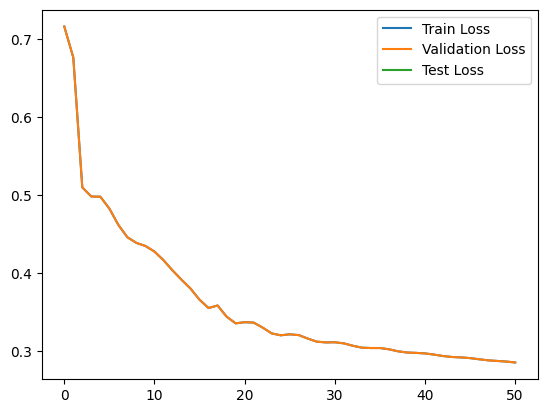

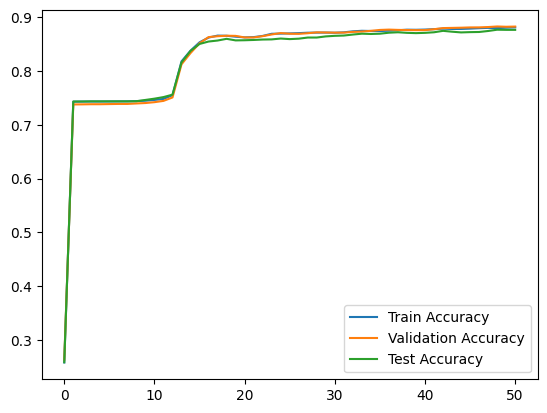

In [ ]:
num_of_feat=g.num_node_features
net=SocialGNN(num_of_feat=num_of_feat,f=16)
criterion=nn.CrossEntropyLoss()
train_social(net,g,epochs=50,initial_lr=0.1)

**Running the model with Different Hyperparameters**

Epoch 1/100, Train_Loss: 0.6848, Train_Accuracy: 0.7249, Val_Accuracy: 0.7200, Test_Accuracy: 0.7252
Epoch 2/100, Train_Loss: 0.5909, Train_Accuracy: 0.7432, Val_Accuracy: 0.7381, Test_Accuracy: 0.7435
Epoch 5/100, Train_Loss: 0.5047, Train_Accuracy: 0.7438, Val_Accuracy: 0.7384, Test_Accuracy: 0.7446
Epoch 6/100, Train_Loss: 0.4913, Train_Accuracy: 0.7446, Val_Accuracy: 0.7400, Test_Accuracy: 0.7459
Epoch 7/100, Train_Loss: 0.4700, Train_Accuracy: 0.7488, Val_Accuracy: 0.7443, Test_Accuracy: 0.7509
Epoch 8/100, Train_Loss: 0.4476, Train_Accuracy: 0.7641, Val_Accuracy: 0.7604, Test_Accuracy: 0.7660
Epoch 9/100, Train_Loss: 0.4304, Train_Accuracy: 0.7942, Val_Accuracy: 0.7910, Test_Accuracy: 0.7942
Epoch 10/100, Train_Loss: 0.4196, Train_Accuracy: 0.8250, Val_Accuracy: 0.8179, Test_Accuracy: 0.8220
Epoch 11/100, Train_Loss: 0.4118, Train_Accuracy: 0.8420, Val_Accuracy: 0.8368, Test_Accuracy: 0.8411
Epoch 12/100, Train_Loss: 0.4045, Train_Accuracy: 0.8504, Val_Accuracy: 0.8467, Test_Accu

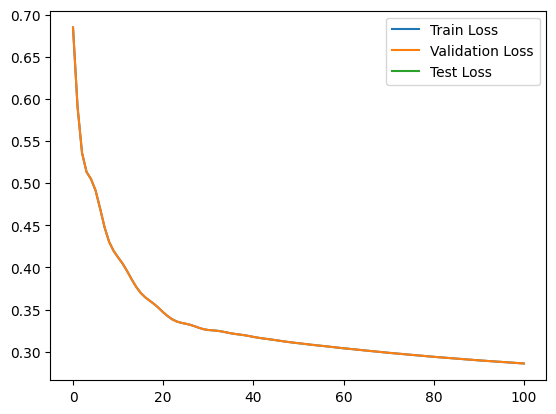

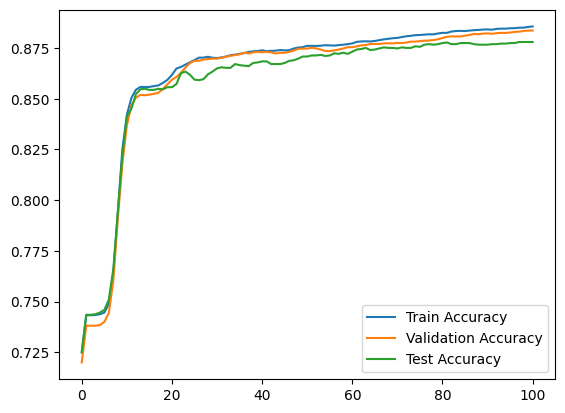

In [ ]:
num_of_feat=g.num_node_features
net=SocialGNN(num_of_feat=num_of_feat,f=16)
criterion=nn.CrossEntropyLoss()
train_social(net,g,epochs=100,initial_lr=0.01)



---



**Making Dataframe out of encoded data**

In [ ]:
X_encoded = pd.DataFrame(data_encoded)

In [ ]:
y = target_df.iloc[:, -1]

In [ ]:
transposed_df = X_encoded.T

In [ ]:
transposed_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,3995,3996,3997,3998,3999,4000,4001,4002,4003,4004
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Naive Bayes**

In [ ]:

# Split the data using 4-Fold Cross Validation
kf = KFold(n_splits=4)
accuracy_scores = []
confusion_matrices = []  # To store confusion matrices for each fold

# Counter variable to keep track of each fold
k = 1

for train_index, test_index in kf.split(y):
    # Split the data into training and testing sets based on the current fold
    X_train, X_test = transposed_df.iloc[train_index], transposed_df.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Define the classifier
    naive_bayes_classifier = GaussianNB()
    naive_bayes_classifier.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = naive_bayes_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    confusion_test = confusion_matrix(y_test, y_pred)

    # Print accuracy for the current iteration
    print(f"Accuracy in iteration {k} is {accuracy * 100:.2f}%")
    k += 1

    # Append the accuracy to the list
    accuracy_scores.append(accuracy)

    # Append the confusion matrix to the list
    confusion_matrices.append(confusion_test)

# Calculate the average accuracy
avg_acc = sum(accuracy_scores) / len(accuracy_scores)

# Calculate the average confusion matrix
avg_confusion_matrix = sum(confusion_matrices) / len(confusion_matrices)

print(f'Average accuracy: {avg_acc * 100:.2f}%')

# Calculate the average confusion matrix as integers
avg_confusion_matrix_int = avg_confusion_matrix.astype(int)
print()
# Print the average confusion matrix
print("Confusion Matrix for Test Data:")
plt.figure(figsize=(6, 4))
sns.heatmap(avg_confusion_matrix_int, annot=True, fmt='d', cmap='viridis',
            xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix -Naive Bayes')
plt.show()
print()


Accuracy in iteration 1 is 44.22%


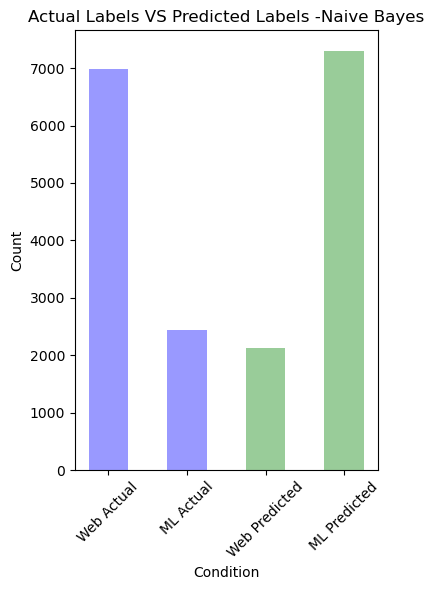

In [ ]:
y_test_0 = len(y_test[y_test == 0])
y_test_1 = len(y_test[y_test == 1])
y_pred_0 = len(y_pred[y_pred == 0])
y_pred_1 = len(y_pred[y_pred == 1])

conditions = ["Web Actual", "ML Actual", "Web Predicted", "ML Predicted"]
colors = ['b', 'b', 'g', 'g']

bar_width = 0.5
x = [i for i in range(len(conditions))]
counts = [y_test_0, y_test_1, y_pred_0, y_pred_1]

plt.figure(figsize=(4, 6))
plt.bar(x, counts, color=colors, width=bar_width, alpha=0.4)
plt.xticks(x, conditions, rotation=45)
plt.xlabel('Condition')
plt.ylabel('Count')
plt.title('Actual Labels VS Predicted Labels -Naive Bayes')
plt.tight_layout()
plt.show()

**Logistic Regression**

Accuracy in iteration 1 is 83.07%

Accuracy in iteration 2 is 83.62%

Accuracy in iteration 3 is 83.28%

Accuracy in iteration 4 is 83.72%

Average accuracy: 83.42%
Confusion Matrix for Test Data:


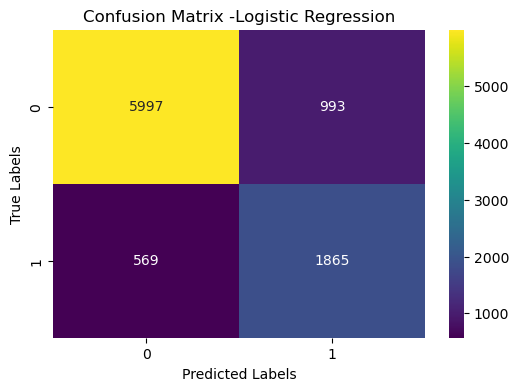

In [ ]:

kf = KFold(n_splits=4, shuffle=True, random_state=42)
accuracy_scores_logisticRegression = []
confusion_matrices_lr = []  # Initialize the confusion matrices list

k = 1

for train_index, test_index in kf.split(transposed_df):  # Changed 'y' to 'transposed_df'
    X_train, X_test = transposed_df.iloc[train_index], transposed_df.iloc[test_index]
    y_train, y_test_lr = y.iloc[train_index], y.iloc[test_index]

    logisticRegression = LogisticRegression(max_iter=1000, solver='liblinear', C=0.1, class_weight='balanced', penalty='l1')
    logisticRegression.fit(X_train, y_train)

    y_pred_lr = logisticRegression.predict(X_test)
    accuracy_logisticRegression = accuracy_score(y_test_lr, y_pred_lr)
    confusion_test_lr = confusion_matrix(y_test_lr, y_pred_lr)

    # Append the confusion matrix to the list
    confusion_matrices_lr.append(confusion_test_lr)

    print(f"Accuracy in iteration {k} is {accuracy_logisticRegression * 100:.2f}%")
    print()

    accuracy_scores_logisticRegression.append(accuracy_logisticRegression)

    k += 1

avg_acc_logisticRegression = np.mean(accuracy_scores_logisticRegression)  # Use np.mean to calculate the average

print(f'Average accuracy: {avg_acc_logisticRegression * 100:.2f}%')

# Calculate the average confusion matrix
avg_confusion_matrix_lr = np.mean(confusion_matrices_lr, axis=0)  # Use np.mean to calculate the average

# Calculate the average confusion matrix as integers
avg_confusion_matrix_int_lr = avg_confusion_matrix_lr.astype(int)

# Print the average confusion matrix
print("Confusion Matrix for Test Data:")
plt.figure(figsize=(6, 4))
sns.heatmap(avg_confusion_matrix_int_lr, annot=True, fmt='d', cmap='viridis',
            xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix -Logistic Regression')
plt.show()

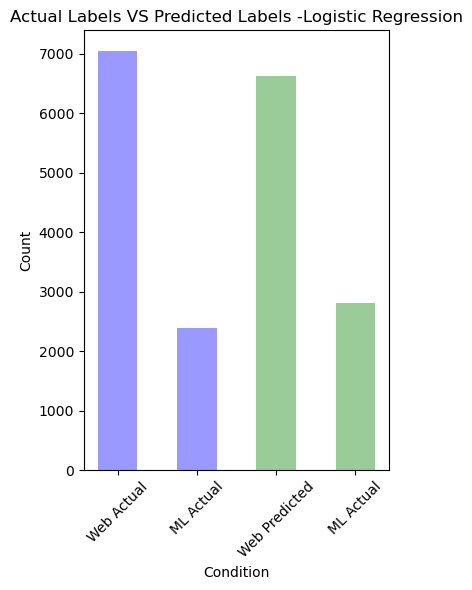

In [ ]:

# Filter data based on conditions for the second dataset
y_test_0_lr = len(y_test_lr[y_test_lr == 0])
y_test_1_lr = len(y_test_lr[y_test_lr == 1])
y_pred_0_lr = len(y_pred_lr[y_pred_lr == 0])
y_pred_1_lr = len(y_pred_lr[y_pred_lr == 1])

conditions = ["Web Actual", "ML Actual", "Web Predicted", "ML Actual"]
colors = ['b', 'b', 'g', 'g']

bar_width = 0.5
x = [i for i in range(len(conditions))]
counts = [y_test_0_lr, y_test_1_lr, y_pred_0_lr, y_pred_1_lr]

plt.figure(figsize=(4, 6))  # Adjust the figure size as needed

# Create the bar chart with the same width and appearance
plt.bar(x, counts, color=colors, width=bar_width, alpha=0.4)
plt.xticks(x, conditions, rotation=45)
plt.xlabel('Condition')
plt.ylabel('Count')
plt.title('Actual Labels VS Predicted Labels -Logistic Regression')
plt.tight_layout()
plt.show()


**Comparing Accuracies**

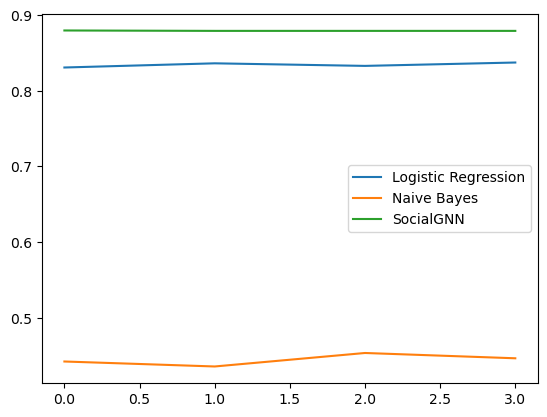

In [ ]:
a=sorted(test_list[-4:], reverse=True)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data for each model with labels and titles
plt.plot(accuracy_scores_logisticRegression, label='Logistic Regression')
plt.plot(accuracy_scores, label='Naive Bayes')
plt.plot(a, label='SocialGNN')

# Add a legend to differentiate the lines
plt.legend()

# Display the plot
plt.show()


Reference:

- Awadelrahman. (2021, July 13). Tutorial Graph Neural networks on social networks. Kaggle. https://www.kaggle.com/code/awadelrahman/tutorial-graph-neural-networks-on-social-networks
- Awan, A. A. (2022, July 21). A Comprehensive Introduction to Graph Neural Networks (GNNs). https://www.datacamp.com/tutorial/comprehensive-introduction-graph-neural-networks-gnns-tutorial
- DARPAtv. (2017, February 15). A DARPA perspective on Artificial intelligence [Video]. YouTube. https://www.youtube.com/watch?v=-O01G3tSYpU
- Khare, P. (2023, August 8). Unravelling Node2Vec: A Guide to Node Embeddings with Python Implementation. Medium. https://medium.com/illumination/unravelling-node2vec-a-guide-to-node-embeddings-with-python-implementation-c131603153bd
- PyG Documentation — pytorch_geometric  documentation. (n.d.). https://pytorch-geometric.readthedocs.io/en/latest/index.html#
- SNAP: Network datasets: Social circles. (n.d.). https://snap.stanford.edu/data/github-social.html
-TensorFlow. (2021, June 17). Intro to graph neural networks (ML Tech Talks) [Video]. YouTube. https://www.youtube.com/watch?v=8owQBFAHw7E




---

